In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import matplotlib.pyplot as plt
import numpy as np
from zipfile import ZipFile
import os
import gdown
from pathlib import Path



In [ ]:
os.makedirs("asl")

In [ ]:
with ZipFile("/content/drive/MyDrive/ZipFiles/cosine-ab-v6.zip", "r") as zipobj:
    zipobj.extractall("asl")

In [ ]:
data_dir = '/content/asl'

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed=123,
    image_size=(256, 256),
    batch_size=64
    )

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256,256),
    batch_size=64
    )

input_shape = (64, 256, 256, 1)
class_names = train_ds.class_names
print(class_names)


Found 2146 files belonging to 2 classes.
Using 1717 files for training.
Found 2146 files belonging to 2 classes.
Using 429 files for validation.
['a', 'b']


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(64, 3, padding="same", activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(64, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Conv2D(32, 3, padding="same", activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
    ])
    


Epoch 1/100
27/27 [==============================] - 29s 356ms/step - loss: 0.6950 - accuracy: 0.4997 - val_loss: 0.6928 - val_accuracy: 0.5315
Epoch 2/100
27/27 [==============================] - 3s 101ms/step - loss: 0.6934 - accuracy: 0.4997 - val_loss: 0.6920 - val_accuracy: 0.5315
Epoch 3/100
27/27 [==============================] - 3s 101ms/step - loss: 0.6929 - accuracy: 0.5178 - val_loss: 0.6920 - val_accuracy: 0.5315
Epoch 4/100
27/27 [==============================] - 3s 101ms/step - loss: 0.6926 - accuracy: 0.5178 - val_loss: 0.6919 - val_accuracy: 0.5315
Epoch 5/100
27/27 [==============================] - 3s 101ms/step - loss: 0.6913 - accuracy: 0.5178 - val_loss: 0.6929 - val_accuracy: 0.5315
Epoch 6/100
27/27 [==============================] - 3s 102ms/step - loss: 0.6943 - accuracy: 0.5125 - val_loss: 0.6923 - val_accuracy: 0.5315
Epoch 7/100
27/27 [==============================] - 3s 101ms/step - loss: 0.6930 - accuracy: 0.5178 - val_loss: 0.6917 - val_accuracy: 0.531

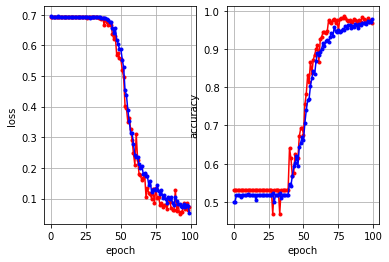

In [ ]:
model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=100)
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
y_acc = history.history['accuracy']
y_vacc = history.history['val_accuracy']

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(np.arange(len(y_vloss)), y_vloss, marker='.', c='red')
ax1.plot(np.arange(len(y_loss)), y_loss, marker='.', c='blue')
ax1.grid()
plt.setp(ax1, xlabel='epoch', ylabel='loss')

ax2.plot(np.arange(len(y_vacc)), y_vacc, marker='.', c='red')
ax2.plot(np.arange(len(y_acc)), y_acc, marker='.', c='blue')
ax2.grid()
plt.setp(ax2, xlabel='epoch', ylabel='accuracy')

plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                    

# Image Prediction

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = 500; //video.videoWidth;
      canvas.height = 500; //video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


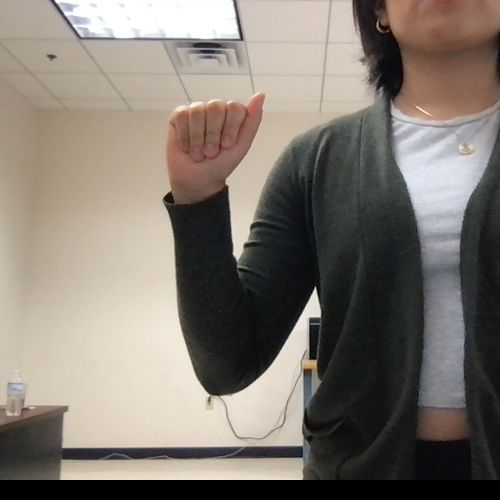

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
 testimage_path = "photo.jpg"

img = tf.keras.utils.load_img(
    testimage_path, target_size=(256, 256)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to b with a 59.50 percent confidence.


# Exporting model 

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model') 

INFO:tensorflow:Assets written to: saved_model/my_model/assets
